In [1]:
# Neural network for multi regression
from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, pi
import random
from random import sample
from sklearn.model_selection import RepeatedKFold
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py # For model saving: https://machinelearningmastery.com/save-load-keras-deep-learning-models/


In [2]:
tf.keras.backend.clear_session()


In [8]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')


train['C0_norm'] = (train.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
#test['C0_norm'] = (test.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
validation['C0_norm'] = (validation.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))

train['lam_norm'] = (train.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
#test['lam_norm'] = (test.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
validation['lam_norm'] = (validation.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))

train['rad_norm'] = (train.rad - min(train.rad))/(max(train.rad) - min(train.rad))
#test['rad_norm'] = (test.rad - min(train.rad))/(max(train.rad) - min(train.rad))
validation['rad_norm'] = (validation.rad - min(train.rad))/(max(train.rad) - min(train.rad))

train['pressure_norm'] = (train.pressure_dim - min(train.pressure_dim))/(max(train.pressure_dim) - min(train.pressure_dim))
#test['pressure_norm'] = (test.pressure_dim - min(train.pressure_dim))/(max(train.pressure_dim) - min(train.pressure_dim))
validation['pressure_norm'] = (validation.pressure_dim - min(train.pressure_dim))/(max(train.pressure_dim) - min(train.pressure_dim))

#train['rad_norm'] = (train.rad - min(train.rad))/(max(train.rad) - min(train.rad))
#validation['rad_norm'] = (validation.rad - min(train.rad))/(max(train.rad) - min(train.rad))



In [9]:
features = ['C0_norm', 'rad_norm', 'pressure_norm', 'lam_norm']

train_x = train[features].to_numpy() 
train_y = train.iloc[:, -104:-4].to_numpy()

validation_x = validation[features].to_numpy()
validation_y = validation.iloc[:, -104:-4].to_numpy()

n_inputs = train_x.shape[1]
n_outputs = train_y.shape[1]

In [10]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(20,  activation='relu'))
    model.add(Dense(100, activation='relu'))
    keras.layers.Dropout(0.25)
    model.add(Dense(100, activation='relu'))
    keras.layers.Dropout(0.25)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_outputs))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Setting the learning rate very low should allow more exploration before minimizing to a local minimum
    model.compile(loss='mae', optimizer=opt, metrics=['mae'])
    return model

In [11]:
# Tutorial on callbacks: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

es = EarlyStopping(
    monitor='mae', 
    verbose=1,
    patience=200,
    mode='min',
    restore_best_weights=True)

mc = ModelCheckpoint(
    'best_model_regression_P.h5', 
    monitor='mae', 
    mode='min', 
    verbose=1,
    patience=200,
    save_best_only=True)


In [12]:
n_inputs, n_outputs = train_x.shape[1], train_y.shape[1]
model = get_model(n_inputs, n_outputs)
model.fit(train_x, train_y, verbose=0, epochs=4000, batch_size=64, callbacks=[es, mc])
        


Epoch 00001: mae improved from inf to 151.10175, saving model to best_model_regression_P.h5

Epoch 00002: mae improved from 151.10175 to 50.29199, saving model to best_model_regression_P.h5

Epoch 00003: mae improved from 50.29199 to 48.45916, saving model to best_model_regression_P.h5

Epoch 00004: mae improved from 48.45916 to 47.88388, saving model to best_model_regression_P.h5

Epoch 00005: mae improved from 47.88388 to 47.46280, saving model to best_model_regression_P.h5

Epoch 00006: mae improved from 47.46280 to 47.27433, saving model to best_model_regression_P.h5

Epoch 00007: mae improved from 47.27433 to 47.14165, saving model to best_model_regression_P.h5

Epoch 00008: mae improved from 47.14165 to 47.01789, saving model to best_model_regression_P.h5

Epoch 00009: mae improved from 47.01789 to 46.68568, saving model to best_model_regression_P.h5

Epoch 00010: mae improved from 46.68568 to 45.49556, saving model to best_model_regression_P.h5

Epoch 00011: mae improved from 4

In [13]:
model = load_model('best_model_regression_P.h5')

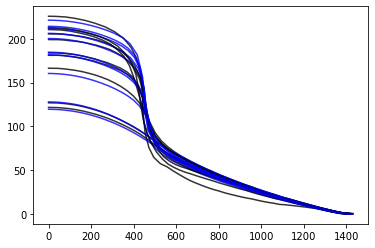

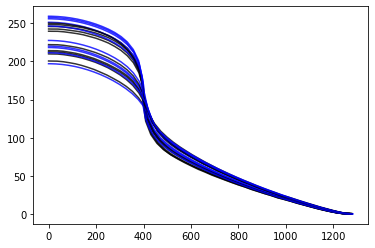

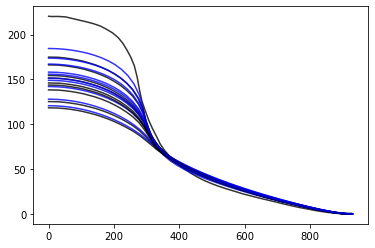

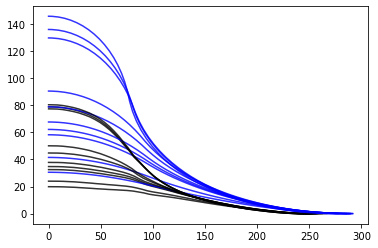

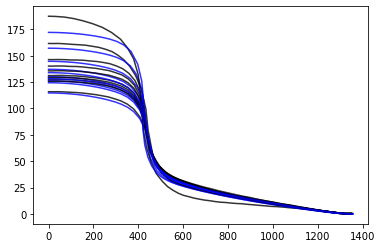

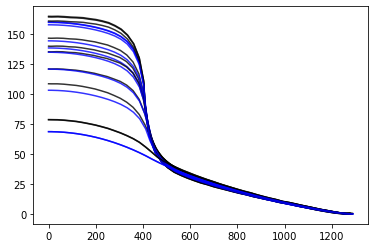

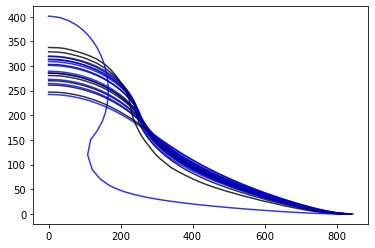

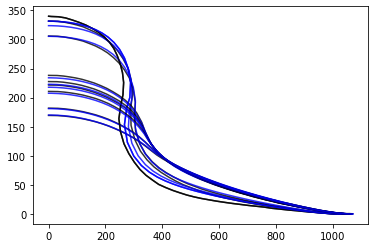

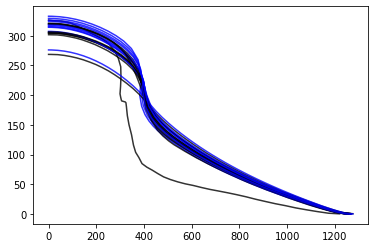

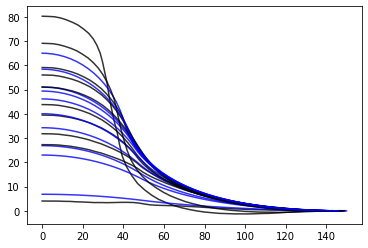

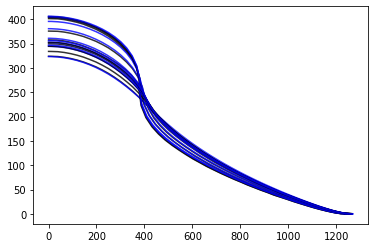

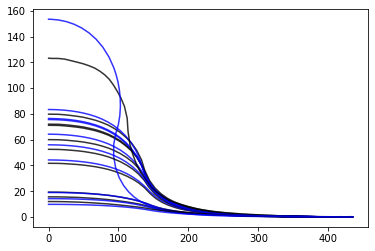

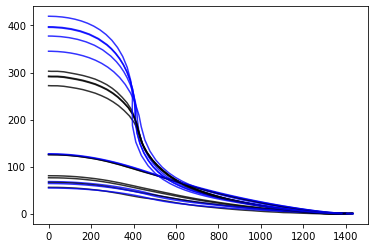

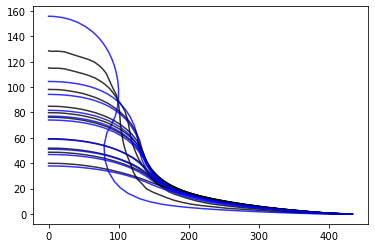

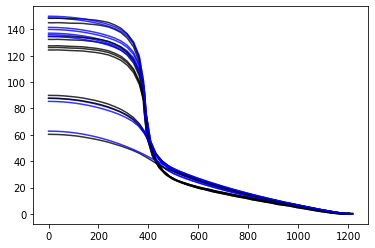

In [14]:
val_omegas = validation.where(validation.omega == 1).dropna(how = 'all')
for i in set(val_omegas.Param_id):
    val_sub = validation.where(validation.Param_id == i).dropna(how = 'all')
    for count in sample(set(np.arange(0,len(val_sub))), 10):
        plt.plot(model.predict(val_sub[features])[count,0:50], model.predict(val_sub[features])[count,50:], label = 'prediction', c = 'black', alpha = .8)
        plt.plot(val_sub.iloc[count, -104:-54], val_sub.iloc[count, -54:-4], label = 'actual', c = 'blue', alpha = .8)
        
    plt.show()

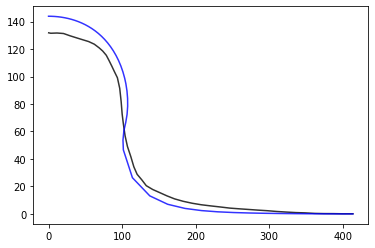

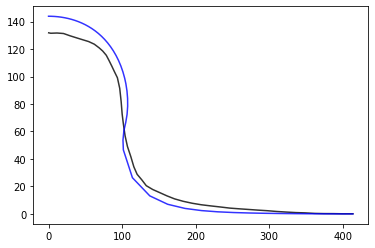

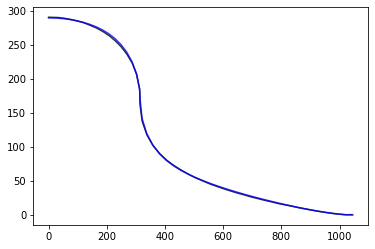

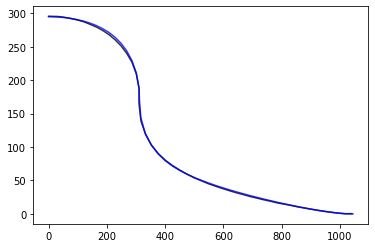

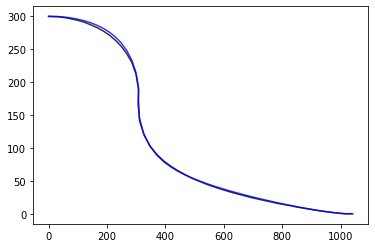

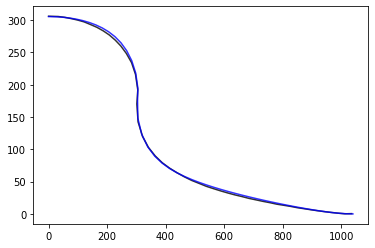

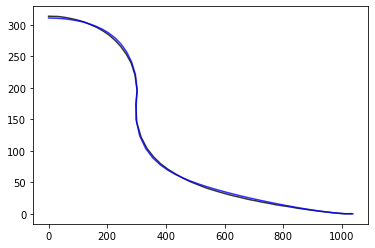

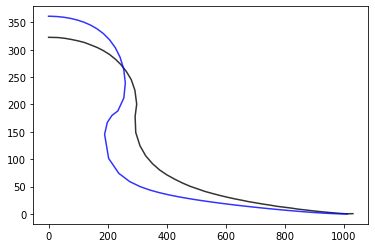

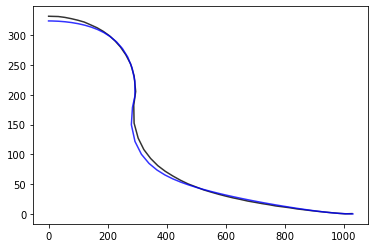

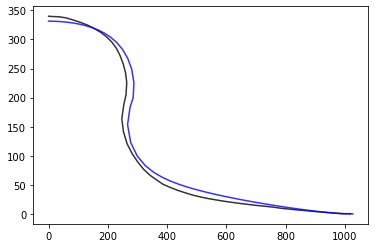

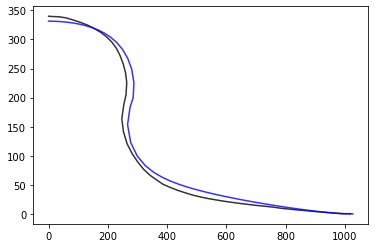

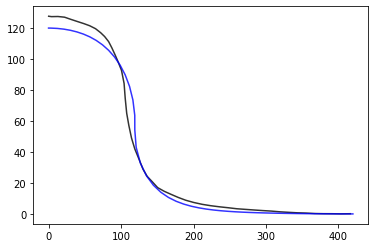

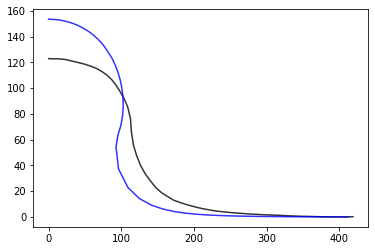

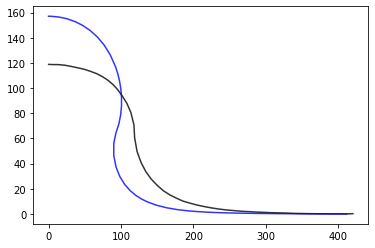

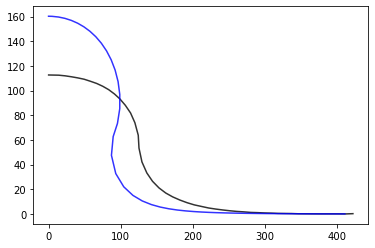

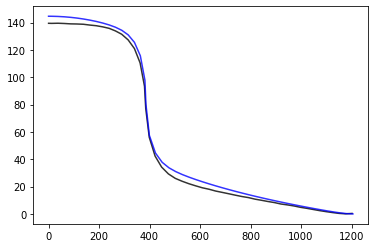

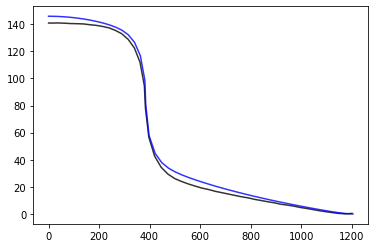

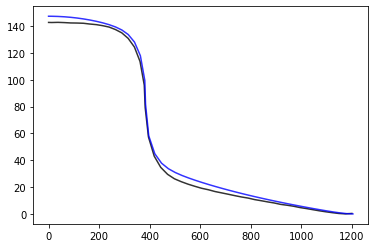

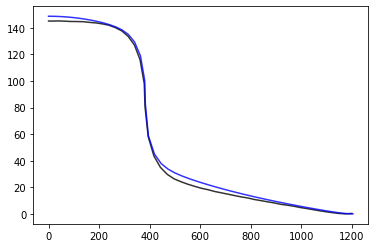

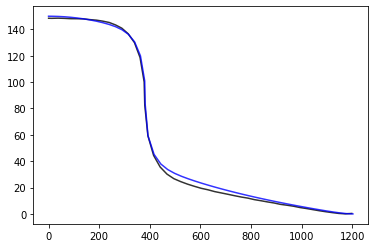

In [16]:
val_omegas = validation.where(validation.omega == 1).dropna(how = 'all')
#for i in set(val_omegas.index):
val_sub = validation.loc[set(val_omegas.index)]


for i in np.arange(0,20):
    plt.plot(model.predict(val_sub[features])[i,0:50], model.predict(val_sub[features])[i,50:100], label = 'prediction', c = 'black', alpha = .8)
    plt.plot(val_sub.iloc[i, -104:-54], val_sub.iloc[i, -54:-4], label = 'actual', c = 'blue', alpha = .8)
    plt.show()
